# Feature Engineering and Pre-Processing for House Price Data
#### By Nick Brooks

### Content: 
- 


In [1]:
# Generael
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Read
train_df = pd.read_csv("house_train.csv", index_col='Id')
test_df = pd.read_csv("house_train.csv", index_col='Id')

# Combine Train and Test for unified processing
combine = [train_df, test_df]

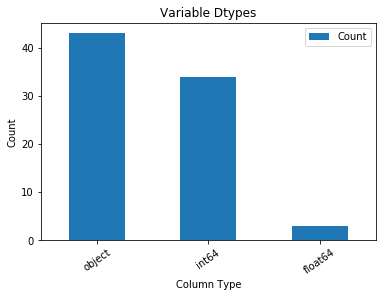

In [3]:
pd.options.display.max_rows = 65
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').sort_values(by=["Count"], ascending=False).plot(kind="bar")
plt.xticks(rotation=35)
plt.ylabel('Count')
plt.title("Variable Dtypes")
plt.show()

In [4]:
object_info = pd.DataFrame()
num_info = pd.DataFrame()

for x in combine[0].columns:
    # Missing Values Dataframe
    if combine[0][x].isnull().any() == True:
        object_info = object_info.append({'Column': x,'dtype': combine[0][x].dtypes,
        'Count': combine[0][x].count().astype(int),
        'Missing %':(combine[0][x].isnull().sum()/combine[0].shape[0])*100,
        'Unique':len(combine[0][x].unique())},ignore_index=True)
    # Custom Descriptive Statistics Table
    if combine[0][x].dtype != "object" :
        num_info = num_info.append({'Column': x, 'dtype': combine[0][x].dtypes, 'Count':
        combine[0][x].count().astype(int), 'Missing %':(combine[0][x].isnull().sum()/combine[0].shape[0])*100,
        'Unique': len(combine[0][x].unique()), 'Stdev':combine[0][x].std(),
        'Mean':combine[0][x].mean(), 'Stdev':combine[0][x].std(),
        'Variance':combine[0][x].var()},ignore_index=True)
object_info.sort_values(by=["Missing %"], ascending=False, inplace=True)

In [5]:
object_info

,Column,Count,Missing %,Unique,dtype
16,PoolQC,7.0,99.520548,4.0,object
18,MiscFeature,54.0,96.301370,5.0,object
1,Alley,91.0,93.767123,3.0,object
17,Fence,281.0,80.753425,5.0,object
10,FireplaceQu,770.0,47.260274,6.0,object
0,LotFrontage,1201.0,17.739726,111.0,float64
11,GarageType,1379.0,5.547945,7.0,object
12,GarageYrBlt,1379.0,5.547945,98.0,float64
13,GarageFinish,1379.0,5.547945,4.0,object
14,GarageQual,1379.0,5.547945,6.0,object


In [6]:
num_info

,Column,Count,Mean,Missing %,Stdev,Unique,Variance,dtype
0,MSSubClass,1460.0,56.897260,0.000000,42.300571,15.0,1.789338e+03,int64
1,LotFrontage,1201.0,70.049958,17.739726,24.284752,111.0,5.897492e+02,float64
2,LotArea,1460.0,10516.828082,0.000000,9981.264932,1073.0,9.962565e+07,int64
3,OverallQual,1460.0,6.099315,0.000000,1.382997,10.0,1.912679e+00,int64
4,OverallCond,1460.0,5.575342,0.000000,1.112799,9.0,1.238322e+00,int64
5,YearBuilt,1460.0,1971.267808,0.000000,30.202904,112.0,9.122154e+02,int64
6,YearRemodAdd,1460.0,1984.865753,0.000000,20.645407,61.0,4.262328e+02,int64
7,MasVnrArea,1452.0,103.685262,0.547945,181.066207,328.0,3.278497e+04,float64
8,BsmtFinSF1,1460.0,443.639726,0.000000,456.098091,637.0,2.080255e+05,int64
9,BsmtFinSF2,1460.0,46.549315,0.000000,161.319273,144.0,2.602391e+04,int64


## Dependent Variable

- Sales Price Matplotlib Histogram
- Log Sales Price Seaborn Histogram

Fairly normally distributed, with a right tail.

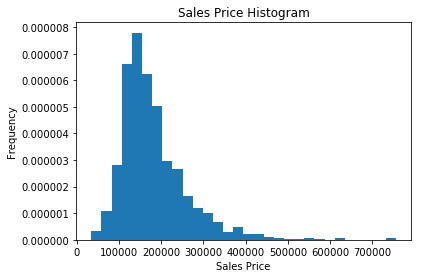

In [7]:
# Histogram with Matplotlib
plt.hist(train_df.SalePrice, normed=True, bins=30)
plt.xlabel('Sales Price')
plt.title('Sales Price Histogram')
plt.ylabel('Frequency');

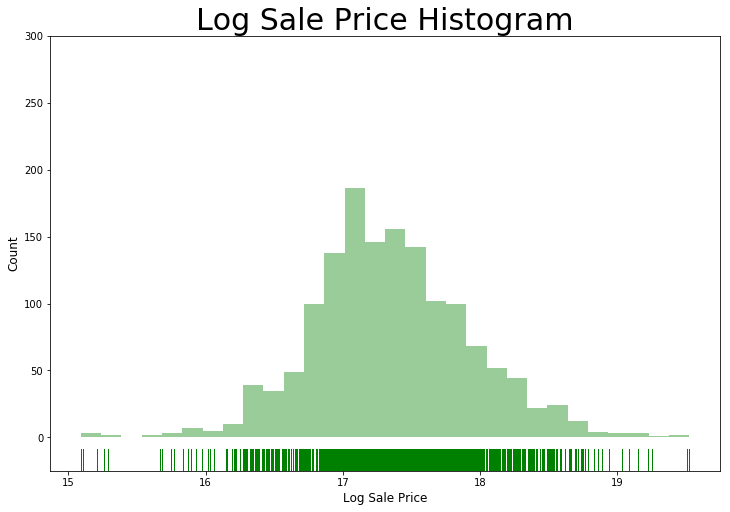

In [8]:
# Log Histogram with Seaborn
plt.figure(figsize=(12,8))
sns.distplot(np.log2(train_df.SalePrice), bins=30, kde=False, rug=True, color="g")
plt.xlabel('Log Sale Price', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Log Sale Price Histogram",fontsize=30)
plt.ylim(-25, 300)
plt.show()

## Missing Values

In [9]:
# Helpers
# Proportion Missing Table:
settypes= combine[0].dtypes.reset_index()
def test_train_mis(test, train):
    missing_test = test.isnull().sum(axis=0).reset_index()
    missing_test.columns = ['column_name', 'test_missing_count']
    missing_test['test_missing_ratio'] = (missing_test['test_missing_count'] / test_df.shape[0])*100
    missing_train = train.isnull().sum(axis=0).reset_index()
    missing_train.columns = ['column_name', 'train_missing_count']
    missing_train['train_missing_ratio'] = (missing_train['train_missing_count'] / train_df.shape[0])*100
    missing = pd.merge(missing_train, missing_test,
                       on='column_name', how='outer',indicator=True,)
    missing = pd.merge(missing,settypes, left_on='column_name', right_on='index',how='inner')
    missing = missing.loc[(missing['train_missing_ratio']>0) | (missing['test_missing_ratio']>0)]\
    .sort_values(by=["train_missing_ratio"], ascending=False)
    missing['Diff'] = missing.train_missing_ratio - missing.test_missing_ratio
    return missing

def missing_plot(train_df):
    missing_df = train_df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df = missing_df.sort_values(by='missing_count')

    ind = np.arange(missing_df.shape[0])
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,18))
    rects = ax.barh(ind, missing_df.missing_count.values, color='red')
    ax.set_yticks(ind)
    ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
    ax.set_xlabel("Count of missing values")
    ax.set_title("Number of missing values in each column")
    plt.show()

## Visualize

Next, I wish to study the difference in missing values between the train and test set.

In [10]:
missing = pd.DataFrame(test_train_mis(combine[0],combine[1]))
missing

,column_name,train_missing_count,train_missing_ratio,test_missing_count,test_missing_ratio,_merge,index,0,Diff
71,PoolQC,1453,99.520548,1453,99.520548,both,PoolQC,object,0.0
73,MiscFeature,1406,96.301370,1406,96.301370,both,MiscFeature,object,0.0
5,Alley,1369,93.767123,1369,93.767123,both,Alley,object,0.0
72,Fence,1179,80.753425,1179,80.753425,both,Fence,object,0.0
56,FireplaceQu,690,47.260274,690,47.260274,both,FireplaceQu,object,0.0
2,LotFrontage,259,17.739726,259,17.739726,both,LotFrontage,float64,0.0
57,GarageType,81,5.547945,81,5.547945,both,GarageType,object,0.0
58,GarageYrBlt,81,5.547945,81,5.547945,both,GarageYrBlt,float64,0.0
59,GarageFinish,81,5.547945,81,5.547945,both,GarageFinish,object,0.0
62,GarageQual,81,5.547945,81,5.547945,both,GarageQual,object,0.0


In [11]:
missing.head()

,column_name,train_missing_count,train_missing_ratio,test_missing_count,test_missing_ratio,_merge,index,0,Diff
71,PoolQC,1453,99.520548,1453,99.520548,both,PoolQC,object,0.0
73,MiscFeature,1406,96.301370,1406,96.301370,both,MiscFeature,object,0.0
5,Alley,1369,93.767123,1369,93.767123,both,Alley,object,0.0
72,Fence,1179,80.753425,1179,80.753425,both,Fence,object,0.0
56,FireplaceQu,690,47.260274,690,47.260274,both,FireplaceQu,object,0.0


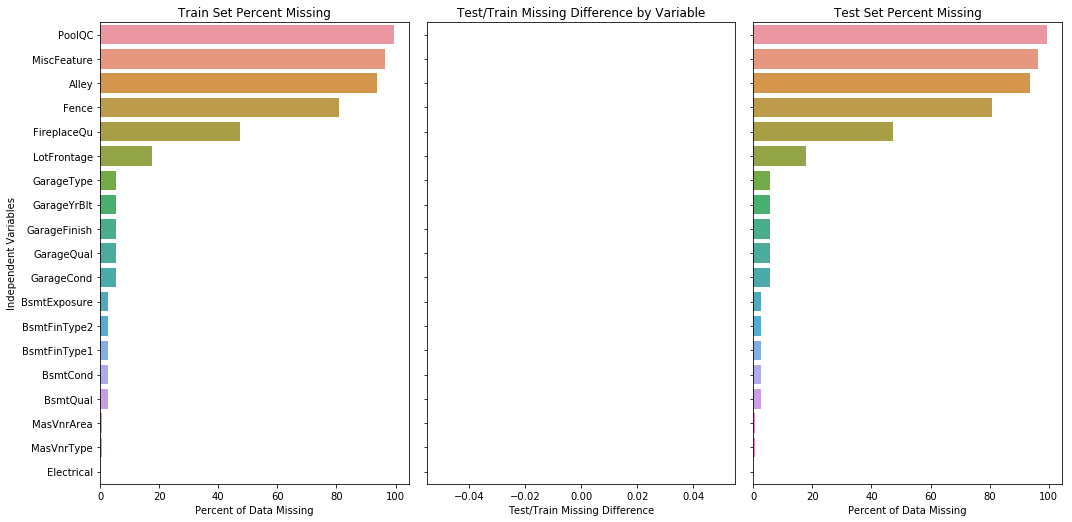

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,8), sharey=True)
ax1 = sns.barplot(y ="column_name", x ="train_missing_ratio", data=missing,ax=ax1)
ax1.set_xlabel('Percent of Data Missing')
ax1.set_title('Train Set Percent Missing')
ax1.set_ylabel('Independent Variables')

ax2 = sns.barplot(y ="column_name", x ="Diff", data=missing,ax=ax2)
ax2.set_xlabel('Test/Train Missing Difference')
ax2.set_title('Test/Train Missing Difference by Variable')
ax2.set_ylabel('')

ax3 = sns.barplot(y ="column_name", x ="test_missing_ratio", data=missing,ax=ax3)
ax3.set_xlabel('Percent of Data Missing')
ax3.set_title('Test Set Percent Missing')
ax3.set_ylabel('')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig("test-train missing values and diff plot.png")

In [13]:
# Delete Columns with High Missing
for i in list(range(len(combine))):
    combine[i].drop(missing.column_name[(missing.train_missing_ratio > 45) |
                                        (missing.test_missing_ratio > 45)],
                    axis=1, inplace=True)

## Imputation

In [14]:
for i in list(range(len(combine))):
    combine[i].loc[:, combine[i].dtypes == float] = combine[i].loc[:, combine[i].dtypes == float].fillna(combine[i].mean())
    combine[i].loc[:, combine[i].dtypes == object] = combine[i].loc[:, combine[i].dtypes == object].fillna(combine[i].mode().iloc[0])
    combine[i].loc[:, combine[i].dtypes == int] =combine[i].loc[:, combine[i].dtypes == int].fillna(combine[i].median())

print("Train Missing Values? -> {}".format(combine[0].isnull().values.any()))
print("Test Missing Values? -> {}".format(combine[1].isnull().values.any()))

Train Missing Values? -> False
Test Missing Values? -> False


In [15]:
"""
RETIRED CODE

 for dataset in combine:
     print(np.count_nonzero(dataset.isnull().values.ravel()))

# Dummy Variables
for i in list(range(len(combine))):
    combine[i] = pd.get_dummies(combine[i],
        columns=combine[i].select_dtypes(include=['object']).columns)
    
diffcols = combine[0].columns.difference(combine[1].columns)
print(diffcols)
SalePrice = combine[0].SalePrice.copy()
combine[0] = combine[0].drop(diffcols, axis=1)

pd.options.display.max_rows = 65
dtype_df = combine[0].dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

combine[0].columns.equals(combine[1].columns)
"""

'\nRETIRED CODE\n\n for dataset in combine:\n     print(np.count_nonzero(dataset.isnull().values.ravel()))\n\n# Dummy Variables\nfor i in list(range(len(combine))):\n    combine[i] = pd.get_dummies(combine[i],\n        columns=combine[i].select_dtypes(include=[\'object\']).columns)\n    \ndiffcols = combine[0].columns.difference(combine[1].columns)\nprint(diffcols)\nSalePrice = combine[0].SalePrice.copy()\ncombine[0] = combine[0].drop(diffcols, axis=1)\n\npd.options.display.max_rows = 65\ndtype_df = combine[0].dtypes.reset_index()\ndtype_df.columns = ["Count", "Column Type"]\ndtype_df.groupby("Column Type").aggregate(\'count\').reset_index()\n\ncombine[0].columns.equals(combine[1].columns)\n'

In [16]:
# Object Variables
combine[0].select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [17]:
combine[0].shape, combine[1].shape

((1460, 75), (1460, 75))

In [18]:
combine[0].to_csv("house_train.csv",header=True,index=True)
combine[1].to_csv("house_test.csv",header=True,index=True)